# **Kelompok 7 - MSE**
- Harianto             [2231110]
- Jefriyanto Chandra   [2231067]
- Bryan Kenedy         [2231141]
- Gary Happydinata     [2231152]
- Randy Heskyel        [2231149]
<br>
<i>Machine Learning project for predicting user's purchase quantity</i>

# **Import Libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from joblib import dump, load
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from datetime import datetime

# **Data Collection**

In [2]:
data = pd.read_csv('data.csv')

# for revert the scaled pred y to it's real value later
unscaled_data = pd.read_csv('data.csv')

data.head()

,Nomor,Umur,Tanggal,Hari,Jenis,Nama,Kode,Kuantitas,Unit,Metode Pembayaran,Harga Penjualan
0,1,50,12/3/2023,Monday,Slingbag,CH,91820LOP,2,pcs,Cash,537143
1,2,42,12/24/2023,Saturday,Dompet,Tumi,2020,2,pcs,Cashless,202717
2,3,55,12/8/2023,Tuesday,Bag,GW,9602,3,pcs,Cash,202967
3,4,30,12/31/2023,Friday,Bag,LV,2020,2,pcs,Cashless,136335
4,5,48,12/16/2023,Friday,Bag,GW,SL002,2,pcs,Cash,420975


# **Data Preparation**

## EDA (Exploratory Data Analysis)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Nomor              1000 non-null   int64 
 1   Umur               1000 non-null   int64 
 2   Tanggal            1000 non-null   object
 3   Hari               1000 non-null   object
 4   Jenis              1000 non-null   object
 5   Nama               1000 non-null   object
 6   Kode               1000 non-null   object
 7   Kuantitas          1000 non-null   int64 
 8   Unit               1000 non-null   object
 9   Metode Pembayaran  1000 non-null   object
 10  Harga Penjualan    1000 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 86.1+ KB


In [4]:
# check dataset columns
data.columns

Index(['Nomor', 'Umur', 'Tanggal', 'Hari', 'Jenis', 'Nama', 'Kode',
       'Kuantitas', 'Unit', 'Metode Pembayaran', 'Harga Penjualan'],
      dtype='object')

In [5]:
# check dataset column data type
data.dtypes

Nomor                 int64
Umur                  int64
Tanggal              object
Hari                 object
Jenis                object
Nama                 object
Kode                 object
Kuantitas             int64
Unit                 object
Metode Pembayaran    object
Harga Penjualan       int64
dtype: object

In [6]:
# show dataset statistics
data.describe()

,Nomor,Umur,Kuantitas,Harga Penjualan
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,500.500000,35.647000,2.069000,260116.091000
std,288.819436,8.844355,0.352652,131348.741321
min,1.000000,5.000000,1.000000,0.000000
25%,250.750000,30.000000,2.000000,169553.500000
50%,500.500000,35.000000,2.000000,259541.000000
75%,750.250000,42.000000,2.000000,350600.000000
max,1000.000000,62.000000,3.000000,746525.000000


In [7]:
data.isnull().sum()

Nomor                0
Umur                 0
Tanggal              0
Hari                 0
Jenis                0
Nama                 0
Kode                 0
Kuantitas            0
Unit                 0
Metode Pembayaran    0
Harga Penjualan      0
dtype: int64

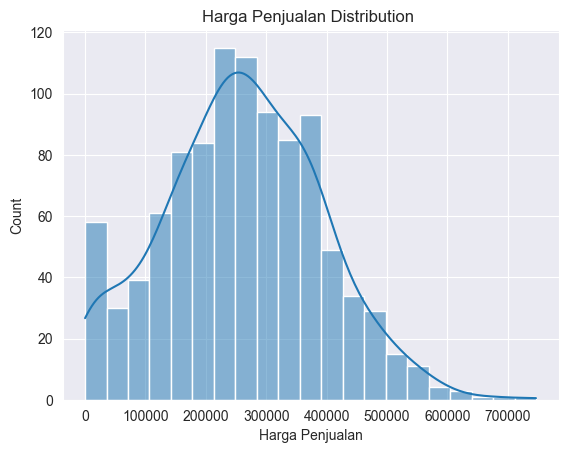

In [8]:
# check `Harga Penjualan` distribution
sns.histplot(data['Harga Penjualan'], kde=True)
plt.title('Harga Penjualan Distribution ')
plt.show()

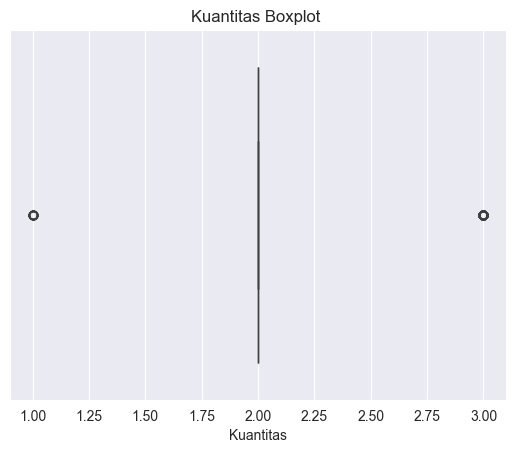

In [9]:
# check `Kuantitas` boxplot
sns.boxplot(x=data['Kuantitas'])
plt.title('Kuantitas Boxplot ')
plt.show()

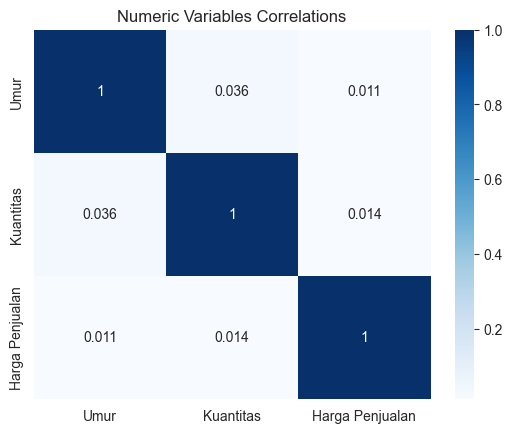

In [10]:
# numveric variables correlations
corr_matrix = data[['Umur', 'Kuantitas', 'Harga Penjualan']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.title('Numeric Variables Correlations')
plt.show()

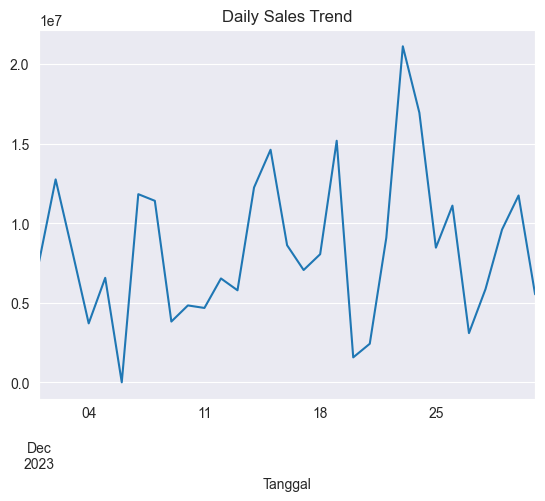

In [11]:
# sales trend by `Tanggal`
data['Tanggal'] = pd.to_datetime(data['Tanggal'])
data.set_index('Tanggal').resample('D')['Harga Penjualan'].sum().plot()
plt.title('Daily Sales Trend')
plt.show()

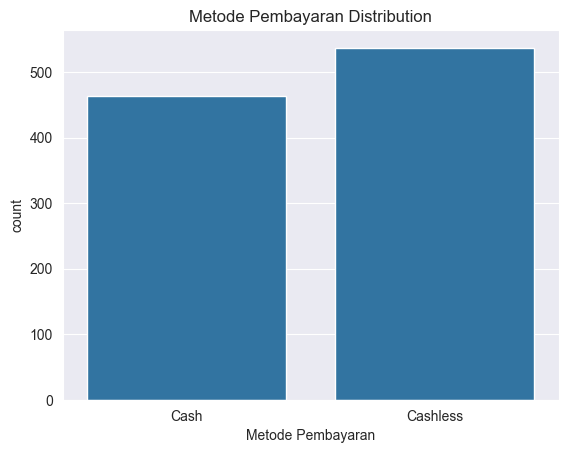

In [12]:
# `Metode Pembayaran` distribution
sns.countplot(x='Metode Pembayaran', data=data)
plt.title('Metode Pembayaran Distribution')
plt.show()

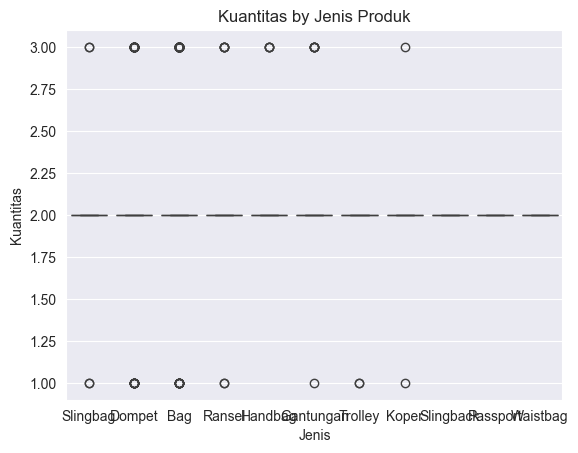

In [13]:
# Correlation between `Jenis Produk` dan `Kuantitas`
sns.boxplot(x='Jenis', y='Kuantitas', data=data)
plt.title('Kuantitas by Jenis Produk')
plt.show()

## Data Cleaning

In [14]:
# concatenate `Nama` and `Jenis` column first
data['Nama'] = data['Jenis'] + ' ' + data['Nama']

# delete `Jenis` column
data = data.drop(['Jenis'], axis=1)

# delete `Nomor` and `Harga Penjualan` columns
data = data.drop(['Nomor', 'Harga Penjualan'], axis=1)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Umur               1000 non-null   int64         
 1   Tanggal            1000 non-null   datetime64[ns]
 2   Hari               1000 non-null   object        
 3   Nama               1000 non-null   object        
 4   Kode               1000 non-null   object        
 5   Kuantitas          1000 non-null   int64         
 6   Unit               1000 non-null   object        
 7   Metode Pembayaran  1000 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 62.6+ KB


In [15]:
# drop null values
data.dropna(inplace=True)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Umur               1000 non-null   int64         
 1   Tanggal            1000 non-null   datetime64[ns]
 2   Hari               1000 non-null   object        
 3   Nama               1000 non-null   object        
 4   Kode               1000 non-null   object        
 5   Kuantitas          1000 non-null   int64         
 6   Unit               1000 non-null   object        
 7   Metode Pembayaran  1000 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 62.6+ KB


In [17]:
# check duplicated data
data.duplicated().sum()

0

## Data normalization

In [18]:
# transform `Tanggal` column into datetime
data['Tanggal'] = pd.to_datetime(data['Tanggal'])
data['Tanggal'] = (data['Tanggal'] - data['Tanggal'].min()).dt.days
data.head()

,Umur,Tanggal,Hari,Nama,Kode,Kuantitas,Unit,Metode Pembayaran
0,50,2,Monday,Slingbag CH,91820LOP,2,pcs,Cash
1,42,23,Saturday,Dompet Tumi,2020,2,pcs,Cashless
2,55,7,Tuesday,Bag GW,9602,3,pcs,Cash
3,30,30,Friday,Bag LV,2020,2,pcs,Cashless
4,48,15,Friday,Bag GW,SL002,2,pcs,Cash


In [19]:
le = {}

# initiate label encoder
for column in ['Hari', 'Nama', 'Kode', 'Unit', 'Metode Pembayaran']:
    le[column] = LabelEncoder()

# transform categorical columns with label encoder
for column in ['Hari', 'Nama', 'Kode', 'Unit', 'Metode Pembayaran']:
    data[column] = le[column].fit_transform(data[column].astype(str))

data.head()

,Umur,Tanggal,Hari,Nama,Kode,Kuantitas,Unit,Metode Pembayaran
0,50,2,1,168,159,2,0,0
1,42,23,2,87,26,2,0,1
2,55,7,5,18,167,3,0,0
3,30,30,0,32,26,2,0,1
4,48,15,0,18,210,2,0,0


In [20]:
# transform numerical column with min max scaler
umur_scaler = MinMaxScaler()
kuantitas_scaler = MinMaxScaler()
data['Umur'] = umur_scaler.fit_transform(data['Umur'].values.reshape(-1, 1))
data['Kuantitas'] = kuantitas_scaler.fit_transform(data['Kuantitas'].values.reshape(-1, 1))

data.head()

,Umur,Tanggal,Hari,Nama,Kode,Kuantitas,Unit,Metode Pembayaran
0,0.789474,2,1,168,159,0.5,0,0
1,0.649123,23,2,87,26,0.5,0,1
2,0.877193,7,5,18,167,1.0,0,0
3,0.438596,30,0,32,26,0.5,0,1
4,0.754386,15,0,18,210,0.5,0,0


In [21]:
def create_directories(directory_paths):
    for directory_path in directory_paths:
        if not os.path.exists(directory_path):
            os.makedirs(directory_path)
            print(f"Directory '{directory_path}' created successfully.")

# create directory first if not exists
directory_paths = ['encoders', 'scalers', 'models']
create_directories(directory_paths)

Directory 'encoders' created successfully.
Directory 'scalers' created successfully.
Directory 'models' created successfully.


In [22]:
# dump encoders and scalers
dump(le, 'encoders/le_encoders.pkl')
dump(umur_scaler, 'scalers/umur_scaler.pkl')
dump(kuantitas_scaler, 'scalers/kuantitas_scaler.pkl')

['scalers/kuantitas_scaler.pkl']

## Split X and Y data

In [23]:
# drop `Kuantitas` predict from X
X = data.drop(['Kuantitas'], axis=1)

# assign `Kuantitas` into y
y = data['Kuantitas']

In [24]:
X

,Umur,Tanggal,Hari,Nama,Kode,Unit,Metode Pembayaran
0,0.789474,2,1,168,159,0,0
1,0.649123,23,2,87,26,0,1
2,0.877193,7,5,18,167,0,0
3,0.438596,30,0,32,26,0,1
4,0.754386,15,0,18,210,0,0
...,...,...,...,...,...,...,...
995,0.491228,18,4,61,175,0,1
996,0.508772,12,4,65,77,0,1
997,0.842105,28,0,30,129,0,0
998,0.315789,13,2,50,170,0,0


In [25]:
y

0      0.5
1      0.5
2      1.0
3      0.5
4      0.5
      ... 
995    0.5
996    1.0
997    0.5
998    0.5
999    0.5
Name: Kuantitas, Length: 1000, dtype: float64

In [26]:
# split the train and test data (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'X_train data length: {len(X_train)}')
print(f'X_test data length: {len(X_test)}')
print(f'y_train data length: {len(y_train)}')
print(f'y_test data length: {len(y_test)}')
n_samples_train, n_features_train = X_train.shape
n_samples_train, n_features_train

X_train data length: 800
X_test data length: 200
y_train data length: 800
y_test data length: 200


(800, 7)

# **Model Training**

In [27]:
# func for get adjusted_r2
def adjusted_r_squared(y_test, y_pred, n_samples, n_features):
    r_squared = r2_score(y_test, y_pred)
    adjusted_r_squared = 1 - (1 - r_squared) * (n_samples - 1) / (n_samples - n_features - 1)
    return adjusted_r_squared

# n_samples and n_features for the train set
n_samples_train, n_features_train = X_train.shape

# n_samples and n_features for the test set
n_samples_test, n_features_test = X_test.shape

## Linear Regression

In [28]:
# initialize
lr = LinearRegression()

# train the model
lr.fit(X_train, y_train)

LinearRegression()

In [29]:
# Linear Regression predict
lr_y_pred_train = lr.predict(X_train)

# evaluate
lr_y_pred_train_mse = mean_squared_error(y_train, lr_y_pred_train)
lr_y_pred_train_mae = mean_absolute_error(y_train, lr_y_pred_train)
lr_y_pred_train_r2 = r2_score(y_train, lr_y_pred_train)
lr_y_pred_train_adjusted_r2 = adjusted_r_squared(y_train, lr_y_pred_train, n_samples_train, n_features_train)

# print
print("Linear Regression Evaluation Metrics")
print(f"Mean Squared Error (MSE):   {lr_y_pred_train_mse:.3f}")
print(f"Mean Absolute Error (MAE):  {lr_y_pred_train_mae:.3f}")
print(f"R-squared Score (R2):       {lr_y_pred_train_r2:.3f}")
print(f"Adjusted R-squared Score:   {lr_y_pred_train_adjusted_r2:.3f}")

Linear Regression Evaluation Metrics
Mean Squared Error (MSE):   0.031
Mean Absolute Error (MAE):  0.090
R-squared Score (R2):       0.015
Adjusted R-squared Score:   0.007


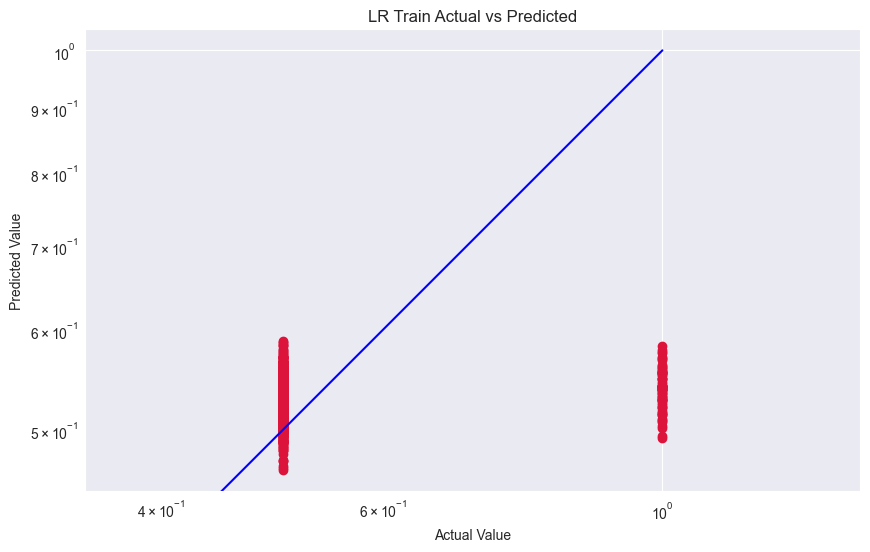

In [30]:
# plot actual vs predicted 
plt.figure(figsize=(10, 6))
plt.scatter(y_train, lr_y_pred_train, c='crimson')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('LR Train Actual vs Predicted')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'b-')
plt.axis('equal')
plt.show()

## XGB Regression

In [31]:
# initialize
xgb = XGBRegressor()

# train the model
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [32]:
# XGB Regression predict
xgb_y_pred_train = xgb.predict(X_train)

# evaluate
xgb_y_pred_train_mse = mean_squared_error(y_train, xgb_y_pred_train)
xgb_y_pred_train_mae = mean_absolute_error(y_train, xgb_y_pred_train)
xgb_y_pred_train_r2 = r2_score(y_train, xgb_y_pred_train)
xgb_y_pred_train_adjusted_r2 = adjusted_r_squared(y_train, xgb_y_pred_train, n_samples_train, n_features_train)

# print
print("XGB Regression Evaluation Metrics")
print(f"Mean Squared Error (MSE):   {xgb_y_pred_train_mse:.3f}")
print(f"Mean Absolute Error (MAE):  {xgb_y_pred_train_mae:.3f}")
print(f"R-squared Score (R2):       {xgb_y_pred_train_r2:.3f}")
print(f"Adjusted R-squared Score:   {xgb_y_pred_train_adjusted_r2:.3f}")

XGB Regression Evaluation Metrics
Mean Squared Error (MSE):   0.000
Mean Absolute Error (MAE):  0.007
R-squared Score (R2):       0.996
Adjusted R-squared Score:   0.996


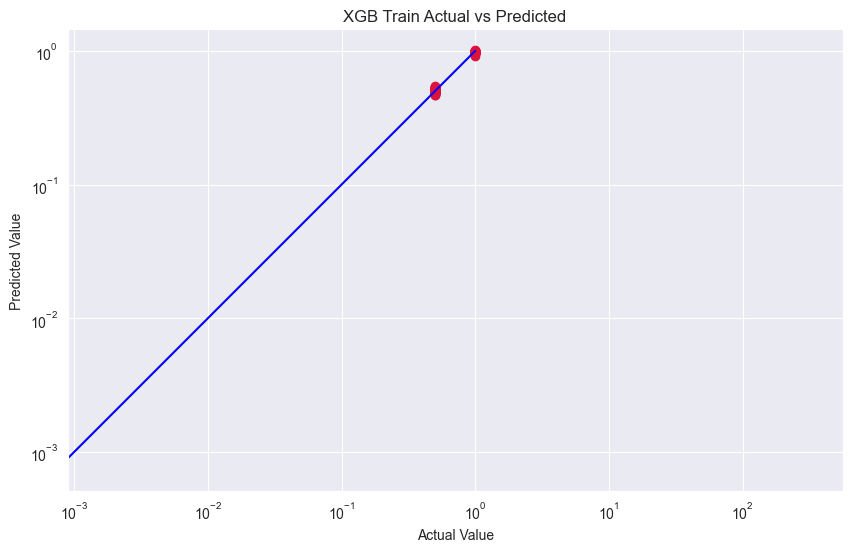

In [33]:
# plot actual vs predicted 
plt.figure(figsize=(10, 6))
plt.scatter(y_train, xgb_y_pred_train, c='crimson')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('XGB Train Actual vs Predicted')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'b-')
plt.axis('equal')
plt.show()

## Random Forest Regression

In [34]:
# initialize
rf = RandomForestRegressor(n_estimators=100, random_state=100)

# train the model
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=100)

In [35]:
# XGB Regression predict
rf_y_pred_train = rf.predict(X_train)

# evaluate
rf_y_pred_train_mse = mean_squared_error(y_train, rf_y_pred_train)
rf_y_pred_train_mae = mean_absolute_error(y_train, rf_y_pred_train)
rf_y_pred_train_r2 = r2_score(y_train, rf_y_pred_train)
rf_y_pred_train_adjusted_r2 = adjusted_r_squared(y_train, rf_y_pred_train, n_samples_train, n_features_train)

# print
print("Random Forest Regression Evaluation Metrics")
print(f"Mean Squared Error (MSE):   {rf_y_pred_train_mse:.3f}")
print(f"Mean Absolute Error (MAE):  {rf_y_pred_train_mae:.3f}")
print(f"R-squared Score (R2):       {rf_y_pred_train_r2:.3f}")
print(f"Adjusted R-squared Score:   {rf_y_pred_train_adjusted_r2:.3f}")

Random Forest Regression Evaluation Metrics
Mean Squared Error (MSE):   0.005
Mean Absolute Error (MAE):  0.040
R-squared Score (R2):       0.845
Adjusted R-squared Score:   0.844


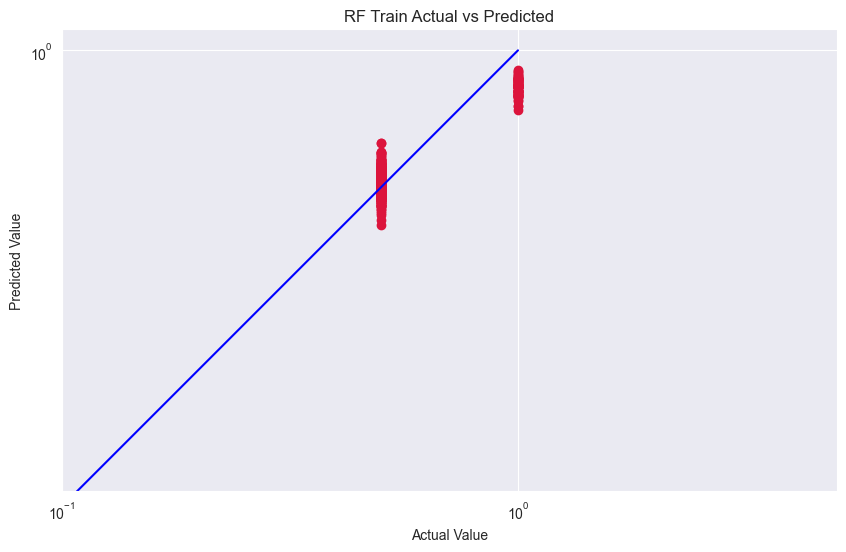

In [36]:
# plot actual vs predicted 
plt.figure(figsize=(10, 6))
plt.scatter(y_train, rf_y_pred_train, c='crimson')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('RF Train Actual vs Predicted')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'b-')
plt.axis('equal')
plt.show()

## GBR Regression

In [37]:
# initialize
gbr = GradientBoostingRegressor()

# train the model
gbr.fit(X_train, y_train)

GradientBoostingRegressor()

In [38]:
# GBR Regression predict
gbr_y_pred_train = gbr.predict(X_train)

# evaluate
gbr_y_pred_train_mse = mean_squared_error(y_train, gbr_y_pred_train)
gbr_y_pred_train_mae = mean_absolute_error(y_train, gbr_y_pred_train)
gbr_y_pred_train_r2 = r2_score(y_train, gbr_y_pred_train)
gbr_y_pred_train_adjusted_r2 = adjusted_r_squared(y_train, gbr_y_pred_train, n_samples_train, n_features_train)

# print
print("GBR Regression Evaluation Metrics")
print(f"Mean Squared Error (MSE):   {gbr_y_pred_train_mse:.3f}")
print(f"Mean Absolute Error (MAE):  {gbr_y_pred_train_mae:.3f}")
print(f"R-squared Score (R2):       {gbr_y_pred_train_r2:.3f}")
print(f"Adjusted R-squared Score:   {gbr_y_pred_train_adjusted_r2:.3f}")

GBR Regression Evaluation Metrics
Mean Squared Error (MSE):   0.020
Mean Absolute Error (MAE):  0.076
R-squared Score (R2):       0.358
Adjusted R-squared Score:   0.352


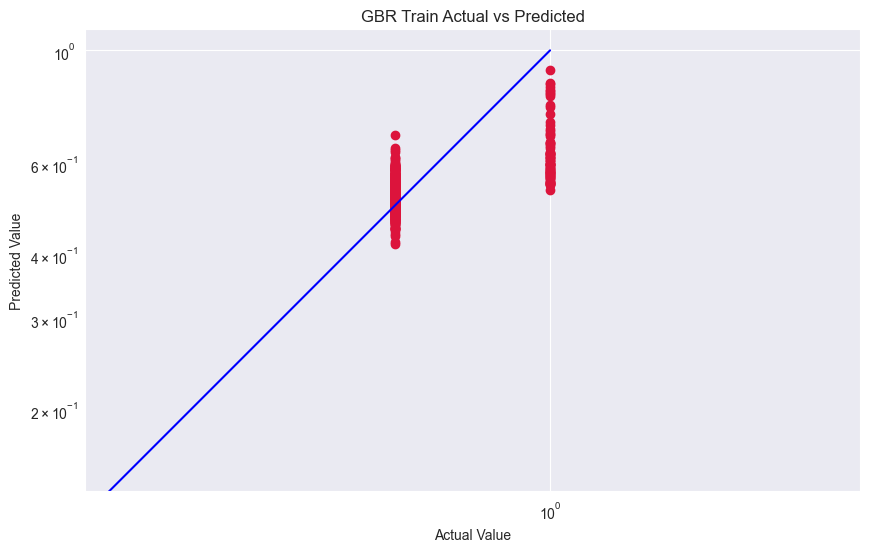

In [39]:
# plot actual vs predicted 
plt.figure(figsize=(10, 6))
plt.scatter(y_train, gbr_y_pred_train, c='crimson')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('GBR Train Actual vs Predicted')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'b-')
plt.axis('equal')
plt.show()

## SVM Regression

In [40]:
# initialize
svr = SVR()

# train the model
svr.fit(X_train, y_train)

SVR()

In [41]:
# SVM Regression predict
svm_y_pred_train = svr.predict(X_train)

# evaluate
svm_y_pred_train_mse = mean_squared_error(y_train, svm_y_pred_train)
svm_y_pred_train_mae = mean_absolute_error(y_train, svm_y_pred_train)
svm_y_pred_train_r2 = r2_score(y_train, svm_y_pred_train)
svm_y_pred_train_adjusted_r2 = adjusted_r_squared(y_train, svm_y_pred_train, n_samples_train, n_features_train)

# print
print("SVM Regression Evaluation Metrics")
print(f"Mean Squared Error (MSE):   {svm_y_pred_train_mse:.3f}")
print(f"Mean Absolute Error (MAE):  {svm_y_pred_train_mae:.3f}")
print(f"R-squared Score (R2):       {svm_y_pred_train_r2:.3f}")
print(f"Adjusted R-squared Score:   {svm_y_pred_train_adjusted_r2:.3f}")

SVM Regression Evaluation Metrics
Mean Squared Error (MSE):   0.034
Mean Absolute Error (MAE):  0.136
R-squared Score (R2):       -0.078
Adjusted R-squared Score:   -0.087


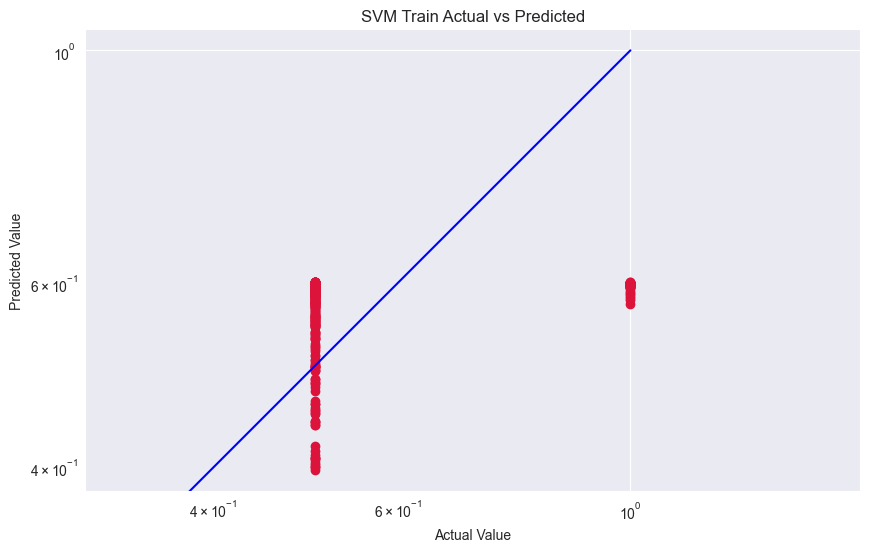

In [42]:
# plot actual vs predicted 
plt.figure(figsize=(10, 6))
plt.scatter(y_train, svm_y_pred_train, c='crimson')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('SVM Train Actual vs Predicted')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'b-')
plt.axis('equal')
plt.show()

# **Save The Trained Model**

In [43]:
# save all the models
dump(lr, 'models/LinearRegression.joblib')
dump(xgb, 'models/XGBRegression.joblib')
dump(rf, 'models/RandomForestRegression.joblib')
dump(gbr, 'models/GBRRegression.joblib')
dump(svr, 'models/SVRRegression.joblib')

['models/SVRRegression.joblib']

# **Test The Models with Testing Data**

## Linear Regression

In [44]:
#  load the saved model
lr_loaded = load('models/LinearRegression.joblib')

In [45]:
# predict
lr_y_pred_test = lr_loaded.predict(X_test)

# evaluate
lr_y_pred_test_mse = mean_squared_error(y_test, lr_y_pred_test)
lr_y_pred_test_mae = mean_absolute_error(y_test, lr_y_pred_test)
lr_y_pred_test_r2 = r2_score(y_test, lr_y_pred_test)
lr_y_pred_test_adjusted_r2 = adjusted_r_squared(y_test, lr_y_pred_test, n_samples_test, n_features_test)

# print
print("Linear Regression Test Evaluation Metrics")
print(f"Mean Squared Error (MSE):   {lr_y_pred_test_mse:.3f}")
print(f"Mean Absolute Error (MAE):  {lr_y_pred_test_mae:.3f}")
print(f"R-squared Score (R2):       {lr_y_pred_test_r2:.3f}")
print(f"Adjusted R-squared Score:   {lr_y_pred_test_adjusted_r2:.3f}")

Linear Regression Test Evaluation Metrics
Mean Squared Error (MSE):   0.030
Mean Absolute Error (MAE):  0.089
R-squared Score (R2):       -0.021
Adjusted R-squared Score:   -0.058


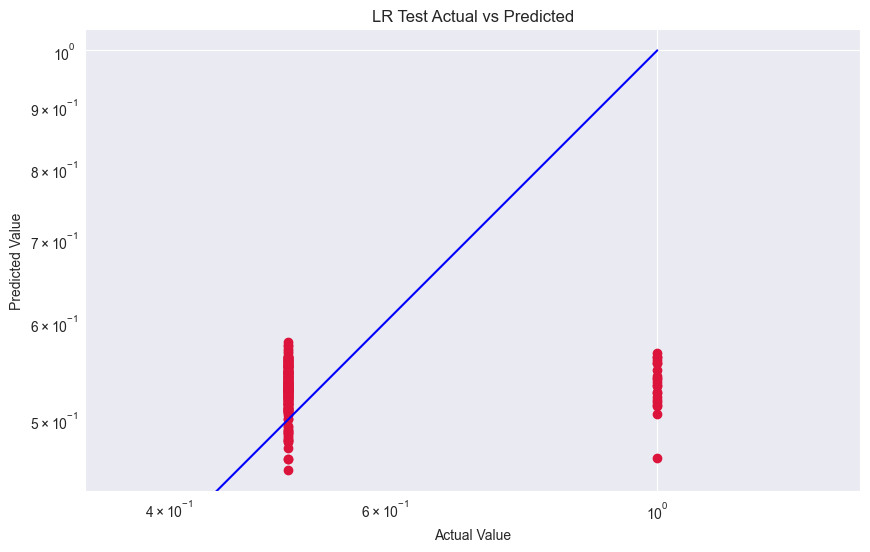

In [46]:
# plot actual vs predicted 
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lr_y_pred_test, c='crimson')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('LR Test Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'b-')
plt.axis('equal')
plt.show()

## XGB Regression

In [47]:
#  load the saved model
xgb_loaded = load('models/XGBRegression.joblib')

In [48]:
# predict
xgb_y_pred_test = xgb_loaded.predict(X_test)

# evaluate
xgb_y_pred_test_mse = mean_squared_error(y_test, xgb_y_pred_test)
xgb_y_pred_test_mae = mean_absolute_error(y_test, xgb_y_pred_test)
xgb_y_pred_test_r2 = r2_score(y_test, xgb_y_pred_test)
xgb_y_pred_test_adjusted_r2 = adjusted_r_squared(y_test, xgb_y_pred_test, n_samples_test, n_features_test)

# print
print("XGB Regression Test Evaluation Metrics")
print(f"Mean Squared Error (MSE):   {xgb_y_pred_test_mse:.3f}")
print(f"Mean Absolute Error (MAE):  {xgb_y_pred_test_mae:.3f}")
print(f"R-squared Score (R2):       {xgb_y_pred_test_r2:.3f}")
print(f"Adjusted R-squared Score:   {xgb_y_pred_test_adjusted_r2:.3f}")

XGB Regression Test Evaluation Metrics
Mean Squared Error (MSE):   0.041
Mean Absolute Error (MAE):  0.132
R-squared Score (R2):       -0.415
Adjusted R-squared Score:   -0.466


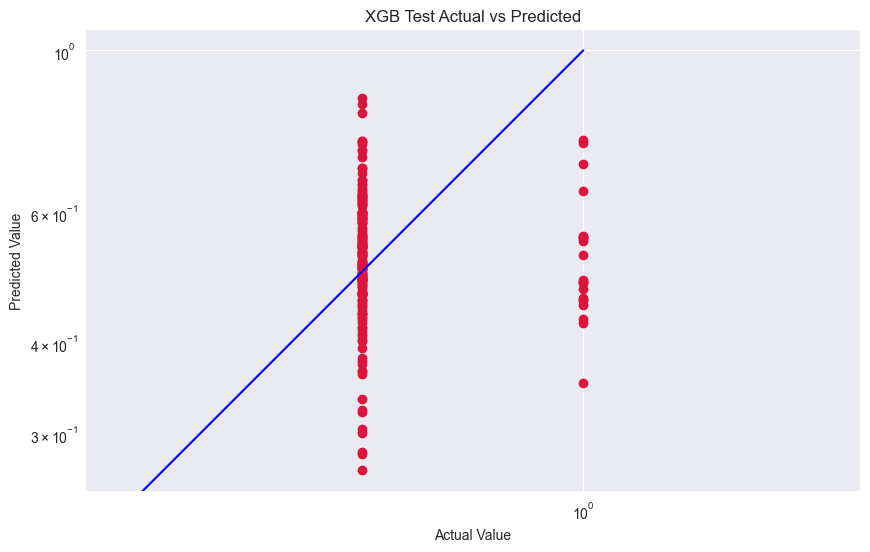

In [49]:
# plot actual vs predicted 
plt.figure(figsize=(10, 6))
plt.scatter(y_test, xgb_y_pred_test, c='crimson')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('XGB Test Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'b-')
plt.axis('equal')
plt.show()

## Random Forest Regression

In [50]:
#  load the saved model
rf_loaded = load('models/RandomForestRegression.joblib')

In [51]:
# predict
rf_y_pred_test = rf_loaded.predict(X_test)

# evaluate
rf_y_pred_test_mse = mean_squared_error(y_test, rf_y_pred_test)
rf_y_pred_test_mae = mean_absolute_error(y_test, rf_y_pred_test)
rf_y_pred_test_r2 = r2_score(y_test, rf_y_pred_test)
rf_y_pred_test_adjusted_r2 = adjusted_r_squared(y_test, rf_y_pred_test, n_samples_test, n_features_test)

# print
print("Random Forest Regression Test Evaluation Metrics")
print(f"Mean Squared Error (MSE):   {rf_y_pred_test_mse:.3f}")
print(f"Mean Absolute Error (MAE):  {rf_y_pred_test_mae:.3f}")
print(f"R-squared Score (R2):       {rf_y_pred_test_r2:.3f}")
print(f"Adjusted R-squared Score:   {rf_y_pred_test_adjusted_r2:.3f}")

Random Forest Regression Test Evaluation Metrics
Mean Squared Error (MSE):   0.032
Mean Absolute Error (MAE):  0.101
R-squared Score (R2):       -0.120
Adjusted R-squared Score:   -0.161


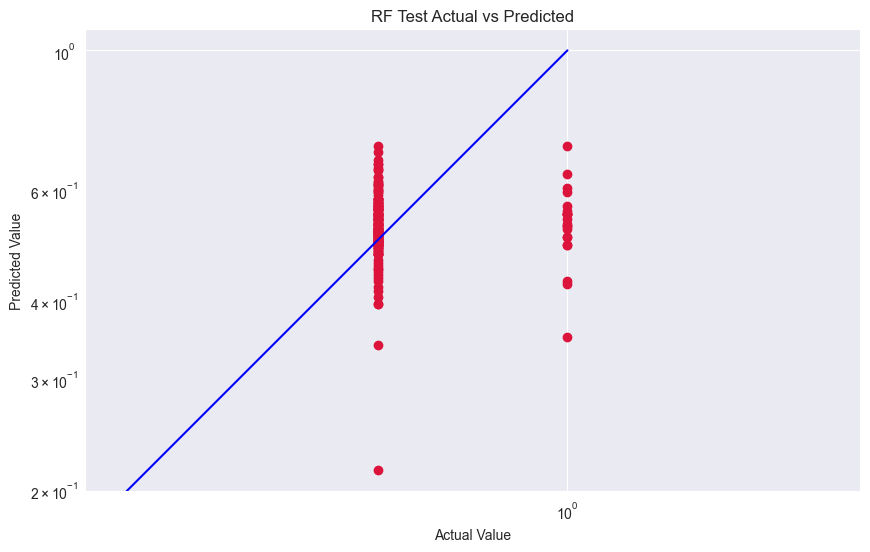

In [52]:
# plot actual vs predicted 
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_y_pred_test, c='crimson')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('RF Test Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'b-')
plt.axis('equal')
plt.show()

## GBR Regression

In [53]:
#  load the saved model
gbr_loaded = load('models/GBRRegression.joblib')

In [54]:
# predict
gbr_y_pred_test = gbr_loaded.predict(X_test)

# evaluate
gbr_y_pred_test_mse = mean_squared_error(y_test, gbr_y_pred_test)
gbr_y_pred_test_mae = mean_absolute_error(y_test, gbr_y_pred_test)
gbr_y_pred_test_r2 = r2_score(y_test, gbr_y_pred_test)
gbr_y_pred_test_adjusted_r2 = adjusted_r_squared(y_test, gbr_y_pred_test, n_samples_test, n_features_test)

# print
print("GBR Regression Test Evaluation Metrics")
print(f"Mean Squared Error (MSE):   {gbr_y_pred_test_mse:.3f}")
print(f"Mean Absolute Error (MAE):  {gbr_y_pred_test_mae:.3f}")
print(f"R-squared Score (R2):       {gbr_y_pred_test_r2:.3f}")
print(f"Adjusted R-squared Score:   {gbr_y_pred_test_adjusted_r2:.3f}")

GBR Regression Test Evaluation Metrics
Mean Squared Error (MSE):   0.034
Mean Absolute Error (MAE):  0.104
R-squared Score (R2):       -0.186
Adjusted R-squared Score:   -0.229


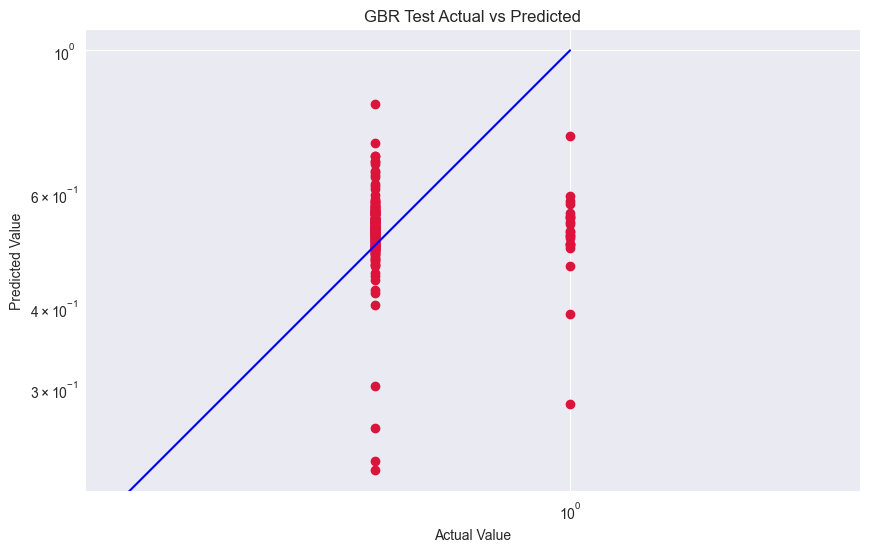

In [55]:
# plot actual vs predicted 
plt.figure(figsize=(10, 6))
plt.scatter(y_test, gbr_y_pred_test, c='crimson')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('GBR Test Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'b-')
plt.axis('equal')
plt.show()

## SVR Regression

In [56]:
#  load the saved model
svr_loaded = load('models/SVRRegression.joblib')

In [57]:
# predict
svr_y_pred_test = svr_loaded.predict(X_test)

# evaluate
svr_y_pred_test_mse = mean_squared_error(y_test, svr_y_pred_test)
svr_y_pred_test_mae = mean_absolute_error(y_test, svr_y_pred_test)
svr_y_pred_test_r2 = r2_score(y_test, svr_y_pred_test)
svr_y_pred_test_adjusted_r2 = adjusted_r_squared(y_test, svr_y_pred_test, n_samples_test, n_features_test)

# print
print("SVR Regression Test Evaluation Metrics")
print(f"Mean Squared Error (MSE):   {svr_y_pred_test_mse:.3f}")
print(f"Mean Absolute Error (MAE):  {svr_y_pred_test_mae:.3f}")
print(f"R-squared Score (R2):       {svr_y_pred_test_r2:.3f}")
print(f"Adjusted R-squared Score:   {svr_y_pred_test_adjusted_r2:.3f}")

SVR Regression Test Evaluation Metrics
Mean Squared Error (MSE):   0.032
Mean Absolute Error (MAE):  0.132
R-squared Score (R2):       -0.093
Adjusted R-squared Score:   -0.133


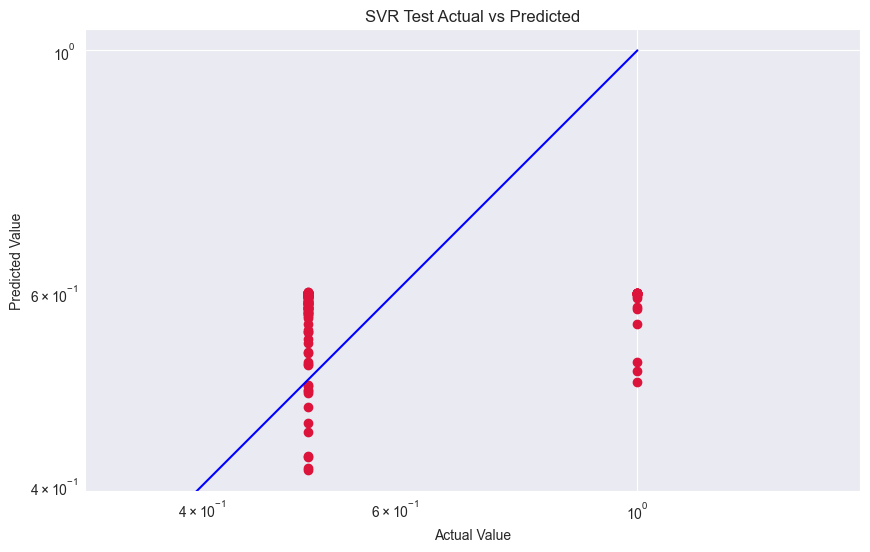

In [58]:
# plot actual vs predicted 
plt.figure(figsize=(10, 6))
plt.scatter(y_test, svr_y_pred_test, c='crimson')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('SVR Test Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'b-')
plt.axis('equal')
plt.show()

# **Create Function For Predict Using Chosen Models**

In [59]:
def predict(nama, umur, kode, metode_pembayaran, tanggal, unit):

    # get day by date
    date_object = datetime.strptime(tanggal, "%m/%d/%Y")
    hari = date_object.strftime("%A")

    data = {
        'Umur': [umur],
        'Tanggal': [tanggal],
        'Hari': [hari],
        'Nama': [nama],
        'Kode': [kode],
        'Unit': [unit],
        'Metode Pembayaran': [metode_pembayaran],
    }

    df = pd.DataFrame(data)

    le_loaded = load('encoders/le_encoders.pkl')
    umur_scaler_loaded = load('scalers/umur_scaler.pkl')
    kuantitas_scaler_loaded = load('scalers/kuantitas_scaler.pkl')

    # check `unseen labels`
    def transform_label(column, value):
        if value in le_loaded[column].classes_:
            return le_loaded[column].transform([value])[0]
        else:
            # unseen label error happened
            raise ValueError(f"Unseen label '{value}' encountered in column '{column}'")

    for column in ['Hari', 'Nama', 'Kode', 'Unit', 'Metode Pembayaran']:
        df[column] = df[column].apply(lambda x: transform_label(column, x))

    df['Tanggal'] = pd.to_datetime(df['Tanggal'])
    df['Tanggal'] = (df['Tanggal'] - df['Tanggal'].min()).dt.days

    df['Umur'] = umur_scaler_loaded.transform(df['Umur'].values.reshape(-1, 1))

    rf_loaded_model = load('models/RandomForestRegression.joblib')
    rf_loaded_pred_scaled = rf_loaded_model.predict(df)
    rf_loaded_pred = kuantitas_scaler_loaded.inverse_transform(rf_loaded_pred_scaled.reshape(-1,1))
    return int(round(rf_loaded_pred[0][0],0))

In [60]:
name = 'Bag Fashion'
age = 47
code = '2930'
payment_method = 'Cashless'
date = '12/3/2023'
unit = 'pcs'

test_qty_pred = predict(name, age, code, payment_method, date, unit)
print(f"Prediction purchase quantity: {test_qty_pred} {unit}")

Prediction purchase quantity: 2 pcs
